## Run configs

In [1]:
import ipywidgets as widgets

### Dataset

In [2]:
selected_dataset = widgets.Dropdown(
    options=[
        'mind2web_test_website',
        'screenspot'
    ],
    description='dataset:',
    disabled=False,
)
selected_dataset

Dropdown(description='dataset:', options=('mind2web_test_website', 'screenspot'), value='mind2web_test_website…

### Batch size

In [3]:
batch_size = widgets.IntSlider(
    value=2,
    min=0,
    max=8,
    step=1,
    description='Batch size:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
batch_size

IntSlider(value=2, continuous_update=False, description='Batch size:', max=8)

In [4]:
test_run = widgets.Dropdown(
    options=[
        True,
        False
    ],
    description='Test run (if True, will only run for 10):',
    disabled=False,
)
test_run

Dropdown(description='Test run (if True, will only run for 10):', options=(True, False), value=True)

## Loading processor

In [5]:
from qwen_vl_utils import process_vision_info

from model.showui.processing_showui import ShowUIProcessor

In [6]:
### ShowUI Preprocessor
# 0. Common setups
min_pixels = 256*28*28
max_pixels = 1344*28*28
# 1. Screenshot -> Graph
uigraph_train = True        # Enable ui graph during training
uigraph_test = True         # Enable ui graph during inference
uigraph_diff = 1            # Pixel difference used for constructing ui graph
uigraph_rand = False        # Enable random graph construction 
# 2. Graph -> Mask 
uimask_pre = True           # Prebuild patch selection mask in the preprocessor (not in model layers) for efficiency
uimask_ratio = 0.5          # Specify the percentage of patch tokens to skip per component
uimask_rand = False         # Enable random token selection instead of uniform selection

### ShowUI Model
lm_skip_ratio = uimask_ratio # valid if not uimask_pre
lm_skip_layer = "[1,28,0]"   # [1,28,1] means we apply UI guide token selection from 1-th to 28-th layer (28 is the last layer of Qwen2-VL)

processor = ShowUIProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", 
    min_pixels=min_pixels, max_pixels=max_pixels,
    uigraph_train=uigraph_train, uigraph_test=uigraph_test, uigraph_diff=uigraph_diff, uigraph_rand=uigraph_rand,
    uimask_pre=True, uimask_ratio=uimask_ratio, uimask_rand=uimask_rand,
)

## Loading dataset & dataloader

In [7]:
from datasets import load_dataset
from torch.utils.data import DataLoader

In [8]:
def normalize_bbox(bbox, resolution):
    """
    Normalize bounding box coordinates to [0, 1] range.
    
    Args:
        bbox: Bounding box coordinates [x1, y1, x2, y2]
        resolution: Image resolution as (width, height) or [width, height]
    
    Returns:
        Normalized bbox [x1, y1, x2, y2] in [0, 1] range
    """
    img_width, img_height = resolution
    x1, y1, x2, y2 = bbox
    
    return [
        x1 / img_width,
        y1 / img_height,
        x2 / img_width,
        y2 / img_height
    ]

In [9]:
_SYSTEM = (
    "Based on the screenshot of the page, "
    "I give a text description and you give its corresponding location. "
    "The coordinate represents a clickable location [x, y] for an element, "
    "which is a relative coordinate on the screenshot, scaled from 0 to 1."
)

def collate_fn(batch):
    messages = []
    bboxes = []
    for t in batch:
        query = t['instruction']
        ground_truth_bbox = t['bbox']
        resolution = t['resolution']
        bboxes.append(normalize_bbox(ground_truth_bbox, resolution))
        
        # Prepare messages
        messages.append([
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": _SYSTEM},
                    {"type": "image", "image": t['image'], "min_pixels": min_pixels, "max_pixels": max_pixels},
                    {"type": "text", "text": query}
                ],
            }
        ])
        
        # Process input
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True,
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=text,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")
    return inputs, bboxes, batch
        

In [10]:
dataset = load_dataset("agent-studio/GroundUI-18K", split="train")
dataset = dataset.filter(
    lambda batch: [s == selected_dataset.value for s in batch["source"]], 
    batched=True
)

if test_run.value:
    dataset = dataset.select(range(10)) 

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Parameter 'function'=<function <lambda> at 0x702dd16e3250> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only shown once. Subsequent hashing failures won't be shown.


Filter:   0%|          | 0/18026 [00:00<?, ? examples/s]

In [11]:
dataset,dataset[0]

(Dataset({
     features: ['image_path', 'image', 'instruction', 'bbox', 'resolution', 'source', 'platform'],
     num_rows: 10
 }),
 {'image_path': '013781df-4391-4533-bcb1-15f6819064f6-79c4a963-4aa9-49c1-9257-6b0d5069c551.jpg',
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
  'instruction': "Click on 'All music'",
  'bbox': [356.0, 461.0, 676.0, 495.0],
  'resolution': [1280, 720],
  'source': 'mind2web_test_website',
  'platform': 'web'})

In [12]:
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size.value, 
    shuffle=True, 
    collate_fn=collate_fn
)

In [13]:
print(f"Selected Dataset: {selected_dataset.value}")
print(f"Dataset Size: {dataset.num_rows}")

Selected Dataset: mind2web_test_website
Dataset Size: 10


## Loading model:

In [14]:
import re

import torch

from model.showui.modeling_showui import ShowUIForConditionalGeneration

In [15]:
lm_qwen_layer = 28

def parse_layer_type(str_ranges, L=lm_qwen_layer, default=0):
    # 0 is without layer token selection, 1 is with layer token selection. Below we provide examples:
    # [1,28,1] means that all LM layers use token selection; [1,28,0] means that do not.
    # Interleaved layer-wise '[2,2,1],[4,4,1],[6,6,1],[8,8,1],[10,10,1],[12,12,1],[14,14,1],[16,16,1],[18,18,1],[20,20,1],[22,22,1],[24,24,1],[26,26,1]'
    result = [default] * L
    
    # Handle None or non-string input
    if str_ranges is None or str_ranges == '':
        return result
    
    # Convert to string if not already
    if not isinstance(str_ranges, str):
        str_ranges = str(str_ranges)
    
    matches = re.findall(r'\[\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\]', str_ranges)
    for start, end, value in matches:
        start, end, value = int(start) - 1, int(end) - 1, int(value)
        if 0 <= start < L and 0 <= end < L:
            result[start:end + 1] = [value] * (end - start + 1)
    return result

lm_skip_layer = parse_layer_type(lm_skip_layer, 28)
# print(lm_skip_layer)

model = ShowUIForConditionalGeneration.from_pretrained(
    "showlab/ShowUI-2B",
    torch_dtype=torch.float16,
    device_map="cuda:0",
    lm_skip_ratio=lm_skip_ratio, lm_skip_layer=lm_skip_layer,
)

/home/khanddorj/Documents/code/ShowUI/.venv/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


## Run the test

In [16]:
import ast

from tqdm import tqdm

In [17]:
def is_click_in_bbox(click_xy, bbox):
    """
    Check if click coordinates are within the bounding box.
    
    Args:
        click_xy: [x, y] coordinates (normalized 0-1)
        bbox: [x_min, y_min, x_max, y_max] (normalized 0-1)
    
    Returns:
        bool: True if click is within bbox
    """
    if not isinstance(click_xy, (list, tuple)) or len(click_xy) != 2:
        return False
    
    x, y = click_xy
    x_min, y_min, x_max, y_max = bbox
    
    return x_min <= x <= x_max and y_min <= y <= y_max

In [39]:
errors = []
corrects = []
total = 0
with torch.no_grad():
    pbar = tqdm(dataloader)
    for inputs, bboxes, metadata in pbar: 
        # Generate prediction
        generated_ids = model.generate(**inputs, max_new_tokens=128)
        
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        output_text = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )
        
        # Parse output
        click_xys = [ast.literal_eval(t) for t in output_text]
        
        # Check accuracy
        is_corrects = []
        for click_xy, ground_truth_bbox in zip(click_xys,bboxes):
            is_corrects.append(is_click_in_bbox(click_xy, ground_truth_bbox))
        
        for i,is_correct in enumerate(is_corrects):
            if is_correct:
                corrects.append({
                    'image_path': metadata[i]['image_path'],
                    'image': metadata[i]['image'],
                    'instruction': metadata[i]['instruction'],
                    'predicted': click_xys[i],
                    'ground_truth_bbox': bboxes[i],
                    'output_text': output_text[i]
                })
            else:
                errors.append({
                    'image_path': metadata[i]['image_path'],
                    'image': metadata[i]['image'],
                    'instruction': metadata[i]['instruction'],
                    'predicted': click_xys[i],
                    'ground_truth_bbox': bboxes[i],
                    'output_text': output_text[i]
                })
        
        total += batch_size.value

        
        pbar.set_description(f"Accuracy: {(len(corrects)/total):.2f}")


accuracy = len(corrects) / total if total > 0 else 0


Accuracy: 0.50: 100%|██████████| 5/5 [01:35<00:00, 19.04s/it]


## Analytics

In [40]:
from collections import Counter

import pandas as pd

### Accuracy bifurcations

In [41]:
correct_id_set = set([
    correct['image_path']+"_"+correct["instruction"] for correct in corrects
])

bifurcation_columns = ['platform']
if selected_dataset.value == "screenspot":
    dataset = dataset.map(
    lambda batch: {
        "platform_type": [a + "_" + b for a, b in zip(batch["image_path"], batch["image_path"])]
    },
    batched=True
)


df_dicts = {}

for column in bifurcation_columns:
    df_dicts[column] = {
        "value":[],
        "total":[],
        "correct":[],
    }
    total_counter = Counter([d[column] for d in dataset])
    correct_counter = Counter([
        d[column] 
        for d in dataset.filter(
            lambda batch: [
                (img + "_" + inst) in correct_id_set 
                for img, inst in zip(batch['image_path'], batch['instruction'])
            ],
            batched=True
        )
    ])

    for k,v in total_counter.items():
        df_dicts[column]['value'].append(k)
        df_dicts[column]['total'].append(v)
        df_dicts[column]['correct'].append(correct_counter.get(k,0))

In [42]:
print(f"Overall accuracy: {accuracy*100:.2f}%")
for column, df_dict in df_dicts.items():
    df = pd.DataFrame(df_dicts[column])
    df['Accuracy'] = df['correct']/df['total']
    print("="*80)
    print(f"{column} bifurcations:")
    print(df.to_string(index=False))
    print("="*80)

Overall accuracy: 50.00%
platform bifurcations:
value  total  correct  Accuracy
  web     10        5       0.5


### Check the biggest errors

In [48]:
import math
from typing import Dict, Any, Tuple

from PIL import Image, ImageDraw

def point_to_bbox_distance(
    bbox: list[float], 
    point: tuple[float, float]
) -> float:
    """
    Calculates the shortest Euclidean distance between an external 2D point 
    and a bounding box.

    It is assumed that the point (px, py) is OUTSIDE the bounding box.

    Args:
        bbox: A list defining the bounding box coordinates: [xmin, ymin, xmax, ymax].
        point: A tuple defining the point coordinates: (px, py).

    Returns:
        The shortest distance (float) between the point and the bounding box.
    """
    
    # 1. Unpack Bounding Box and Point coordinates
    xmin, ymin, xmax, ymax = bbox
    px, py = point

    # 2. Find the coordinates (closest_x, closest_y) on the rectangle 
    #    that are closest to the point (px, py).

    # For the X-coordinate:
    # If px is left of xmin, closest_x is xmin.
    # If px is right of xmax, closest_x is xmax.
    # If px is between xmin and xmax, closest_x is px.
    # The combination of max and min achieves this logic cleanly.
    closest_x = max(xmin, min(px, xmax))

    # For the Y-coordinate:
    # If py is below ymin, closest_y is ymin.
    # If py is above ymax, closest_y is ymax.
    # If py is between ymin and ymax, closest_y is py.
    closest_y = max(ymin, min(py, ymax))

    # 3. Calculate the distance components (deltas)
    dx = px - closest_x
    dy = py - closest_y

    # 4. Calculate the Euclidean distance (distance = sqrt(dx^2 + dy^2))
    distance = math.sqrt(dx**2 + dy**2)
    
    return distance

def visualize_error_on_image(
    error_data: Dict[str, Any], 
    point_radius: int = 5, 
    bbox_color: Tuple[int, int, int] = (255, 0, 0),  # Red
    point_color: Tuple[int, int, int] = (0, 0, 255), # Blue
    line_width: int = 3
) -> Image.Image:
    """
    Draws the ground truth bounding box and the predicted point on a given image.

    Args:
        error_data: A dictionary containing 'image' (PIL.Image.Image), 
                    'ground_truth_bbox' (normalized [xmin, ymin, xmax, ymax]),
                    and 'predicted' (normalized [x, y]).
        point_radius: Radius for the circle representing the predicted point.
        bbox_color: RGB tuple for the bounding box color.
        point_color: RGB tuple for the predicted point color.
        line_width: Width of the lines for drawing.

    Returns:
        A PIL.Image.Image object with the annotations drawn.
    """
    image = error_data['image'].copy() # Work on a copy to avoid modifying original
    draw = ImageDraw.Draw(image)

    img_width, img_height = image.size

    # Convert normalized bbox to absolute pixel coordinates
    xmin_norm, ymin_norm, xmax_norm, ymax_norm = error_data['ground_truth_bbox']
    bbox_abs = [
        int(xmin_norm * img_width),
        int(ymin_norm * img_height),
        int(xmax_norm * img_width),
        int(ymax_norm * img_height)
    ]

    # Draw the bounding box
    draw.rectangle(bbox_abs, outline=bbox_color, width=line_width)

    # Convert normalized predicted point to absolute pixel coordinates
    px_norm, py_norm = error_data['predicted']
    point_abs = (
        int(px_norm * img_width),
        int(py_norm * img_height)
    )

    # Draw the predicted point as a circle
    # Calculate bounding box for the circle
    circle_bbox = [
        point_abs[0] - point_radius,
        point_abs[1] - point_radius,
        point_abs[0] + point_radius,
        point_abs[1] + point_radius,
    ]
    draw.ellipse(circle_bbox, fill=point_color, outline=point_color)
    
    # Optionally, draw a cross for more visibility
    draw.line([point_abs[0] - point_radius, point_abs[1], point_abs[0] + point_radius, point_abs[1]], fill=point_color, width=line_width-1)
    draw.line([point_abs[0], point_abs[1] - point_radius, point_abs[0], point_abs[1] + point_radius], fill=point_color, width=line_width-1)


    return image

In [44]:
for i, e in enumerate(errors):
    errors[i]['distance'] = point_to_bbox_distance(e['ground_truth_bbox'],e['predicted'])

biggest_errors = sorted(errors,key=lambda x: x['distance'])[-5:]

In [ ]:
def visualize_ui_graph(error):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": error['instruction']},
                {
                    "type": "image",
                    "image": error['image'],
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                },
            ],
        }
    ]

    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True,
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
        vis_dir="temp", # if provided, will be used to save the visualized img
    )

    return Image.open('temp/demo.png')

Instruction: Click on "Computers & Office Equipment".
Distance: 0.8916754704321709
Bounding box and the point


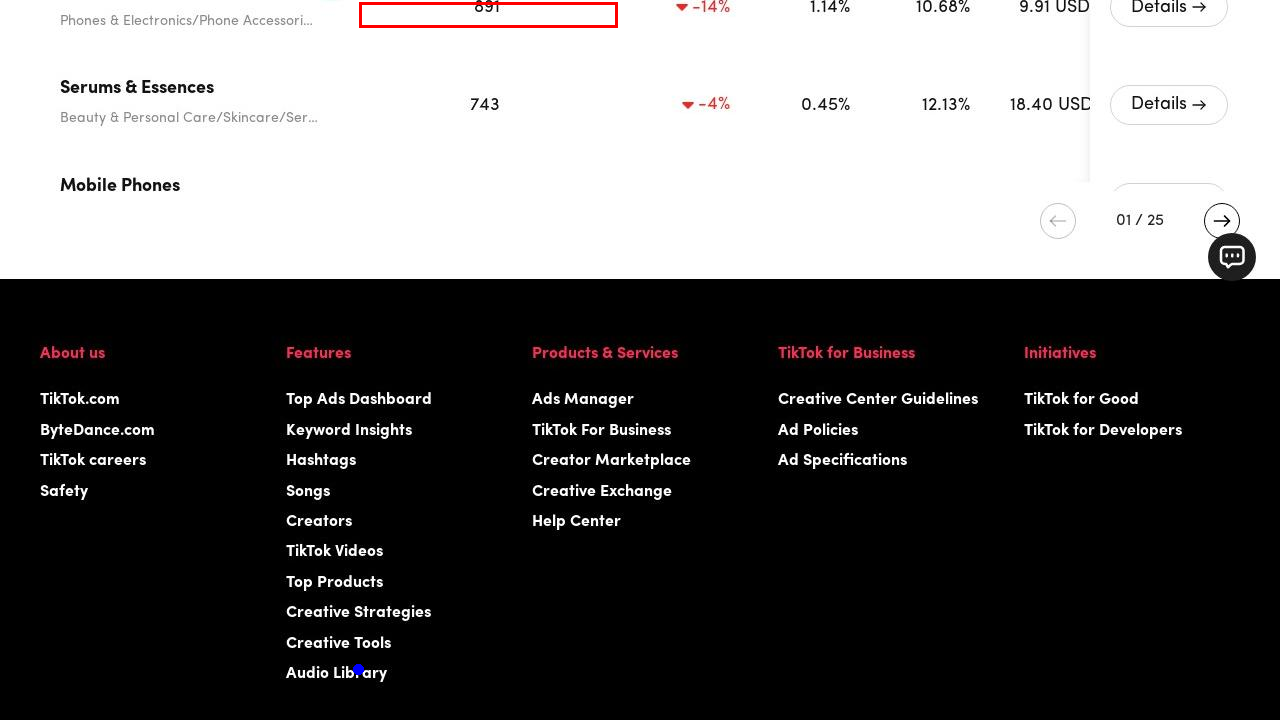

UI Graph applied:


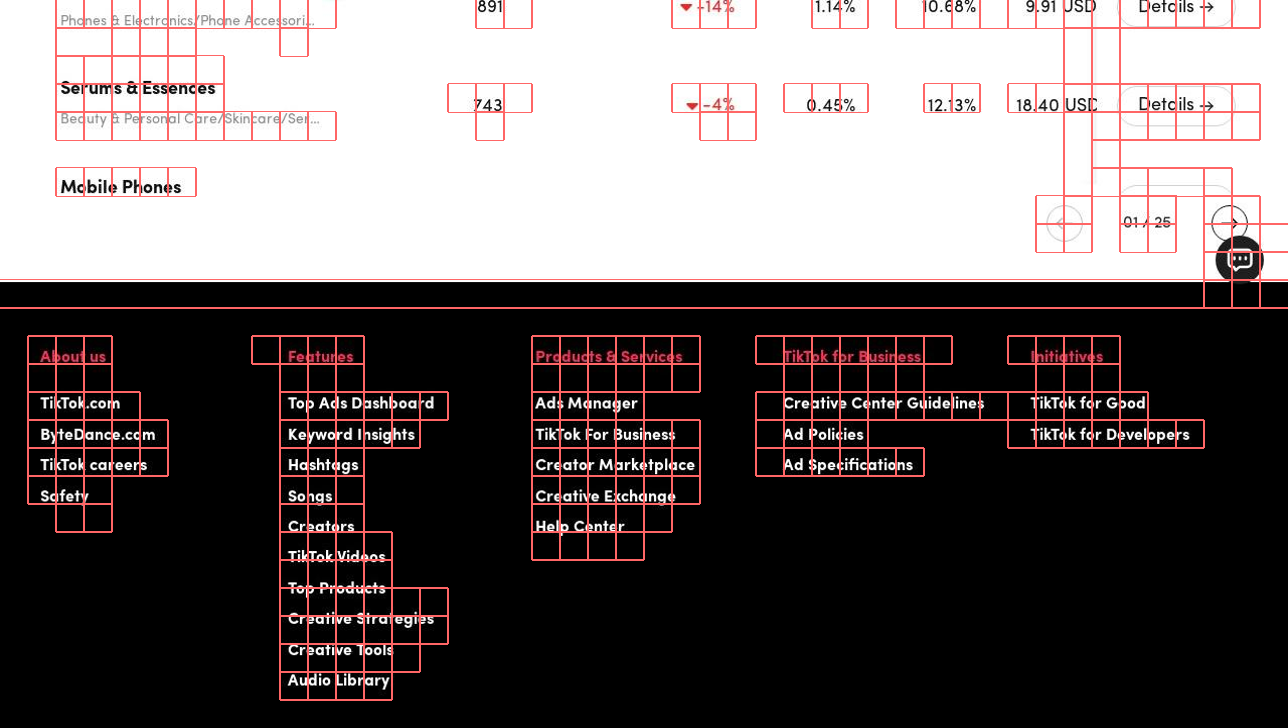

In [ ]:
error = biggest_errors[4]
print(f"Instruction: {error['instruction']}")
print(f"Distance: {error['distance']}")
print("Bounding box and the point")
display(visualize_error_on_image(error))
print("UI Graph applied:")
display(visualize_ui_graph(error))

## Writing results